# Issue Workflow

In [1]:
using DataFramesMeta, CSV, Kroki
dir = pwd() * "/";

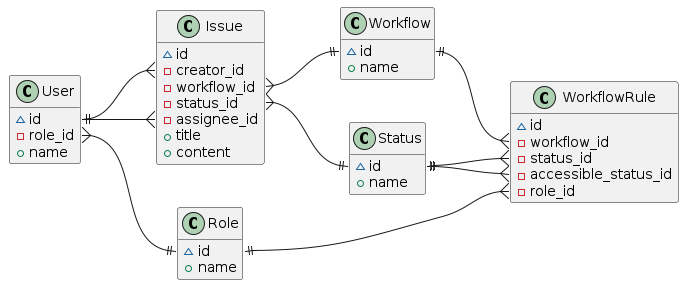

In [2]:
plantuml"""
class Role {
    ~ id
    + name
}
class User {
    ~ id
    - role_id
    + name
}
class Issue {
    ~ id
    - creator_id
    - workflow_id
    - status_id
    - assignee_id
    + title
    + content
}
class Status {
    ~ id
    + name
}
class Workflow {
    ~ id
    + name
}
class WorkflowRule {
    ~ id
    - workflow_id
    - status_id
    - accessible_status_id
    - role_id
}
hide methods
left to right direction

User::id ||--{ Issue::creator_id
User::id ||--{ Issue::assignee_id
Issue::workflow_id }--|| Workflow::id
Issue::status_id }--|| Status::id
Workflow::id ||--{ WorkflowRule::workflow_id
Status::id ||--{ WorkflowRule::status_id
Status::id ||--{ WorkflowRule::accessible_status_id
User::role_id }--|| Role::id
Role::id ||--{ WorkflowRule::role_id
"""

## Example

In [3]:
# roles
roles = CSV.read(dir * "roles.csv", DataFrame)

Row,id,name
,Int64,String7
1,1,manager
2,2,staff


In [4]:
# users
users = CSV.read(dir * "users.csv", DataFrame)
users |> display
leftjoin(users, roles, on= :role_id => :id, renamecols = "" => "_of_role")

Row,id,role_id,name
,Int64,Int64,String15
1,1,1,管理 花子
2,2,2,一般 太郎


Row,id,role_id,name,name_of_role
,Int64,Int64,String15,String7?
1,1,1,管理 花子,manager
2,2,2,一般 太郎,staff


In [5]:
# statuses
statuses = CSV.read(dir * "statuses.csv", DataFrame)

Row,id,name
,Int64,String15
1,1,Untouched
2,2,WIP
3,3,Done
4,4,Closed


In [6]:
# workflows
workflows = CSV.read(dir * "workflows.csv", DataFrame)

Row,id,name
,Int64,String7
1,1,Task
2,2,Problem


In [7]:
# workflow_rules
workflow_rules = CSV.read(dir * "workflow_rules.csv", DataFrame)
@chain workflow_rules first(5) display
@chain workflow_rules begin
    leftjoin(select(workflows, :id, :name => :workflow_name), on= :workflow_id => :id)
    leftjoin(select(statuses, :id, :name => :status_name), on= :status_id => :id)
    leftjoin(select(statuses, :id, :name => :accessible_status_name), on= :accessible_status_id => :id)
    leftjoin(select(roles, :id, :name => :role_name), on= :role_id => :id)
    select(:id, :workflow_name, :status_name, :accessible_status_name, :role_name)
end

Row,id,workflow_id,status_id,accessible_status_id,role_id
,Int64,Int64,Int64,Int64,Int64
1,1,1,1,2,1
2,2,1,1,2,2
3,5,1,1,4,1
4,6,1,1,4,2
5,9,1,2,4,1


Row,id,workflow_name,status_name,accessible_status_name,role_name
,Int64,String7?,String15?,String15?,String7?
1,1,Task,Untouched,WIP,manager
2,2,Task,Untouched,WIP,staff
3,5,Task,Untouched,Closed,manager
4,6,Task,Untouched,Closed,staff
5,9,Task,WIP,Closed,manager
6,10,Task,WIP,Closed,staff
7,16,Problem,Untouched,WIP,staff
8,19,Problem,Untouched,Closed,manager
9,22,Problem,WIP,Done,staff


### WorkflowRule matrix of Task

*Manager*

| status \ accessible_status | Untouched | WIP | Done | Closed |
|:--|:-:|:-:|:-:|:-:|
| Untouched | - | ✅ | - | ✅ |
| WIP | - | - | - | ✅ |
| Done | - | - | - | - |
| Closed | - | - | - | - |

*Staff*

| status \ accessible_status | Untouched | WIP | Done | Closed |
|:--|:-:|:-:|:-:|:-:|
| Untouched | - | ✅ | - | ✅ |
| WIP | - | - | - | ✅ |
| Done | - | - | - | - |
| Closed | - | - | - | - |


### WorkflowRule matrix of Problem

*Manager*

| status \ accessible_status | Untouched | WIP | Done | Closed |
|:--|:-:|:-:|:-:|:-:|
| Untouched | - | - | - | ✅ |
| WIP | - | - | - | ✅ |
| Done | - | ✅ | - | ✅ |
| Closed | - | - | - | - |

*Staff*

| status \ accessible_status | Untouched | WIP | Done | Closed |
|:--|:-:|:-:|:-:|:-:|
| Untouched | - | ✅ | - | - |
| WIP | - | - | ✅ | - |
| Done | - | ✅ | - | - |
| Closed | - | - | - | - |